# Tropical Cyclone Damage Assesment

The 2024 EY Data Science challenge focuses on coastal resilience and
climate change. Participants will use high-resolution
satellite datasets to build predictive models to help
vulnerable coastal communities adapt to evolving
conditions and recover from extreme climate events.
These solutions will result in new and innovative ideas
designed to increase the impact of data for societal
benefit.

Our team is participating in this data challenge focusing on the devastating impact of Hurricane Maria on Puerto Rico, particularly the southeast coast near Yabucoa. This hurricane, which struck on September 20, 2017, brought maximum winds of 135 knots and crossed the island diagonally from southeast to northwest over approximately 8 hours before moving into the Atlantic Ocean.

The challenge utilizes high-value satellite data provided by Maxar's Open Data Program, estimated at $30,000 USD. This commercial data is renowned for its quality and detail, making it the best available for assessing storm damage from space. Maxar's Open Data Program, initiated in January 2017, aims to support humanitarian response efforts by providing timely and actionable information during disasters. Their imagery is processed to include orthorectification, atmospheric compensation, and pansharpening, ensuring accurate and clear representations of the affected areas.

For this challenge, our team has been provided with two datasets from Maxar's GEO-1 mission: one captured before the hurricane (August 29, 2017) and the other after the storm (October 12, 2017). These datasets, in common cloud-optimized GeoTIFF (COG) format, will enable us to analyze the impact of Hurricane Maria on Puerto Rico and assess the extent of damage caused.

The goal is to develop an object detection model which should be designed to identify the buildings and classify them into the following four categories: Residential Undamaged Building, Residential Damaged Building, Commercial Undamaged Building, Commercial Damaged Building.

As to the evalution of the model, an out-of-sample validation dataset is provided. The submissions/predictions
(.zip file) are submitted via the portal, and automatically get compared with the ground truth file and a metric mAP (Mean Average
Precision) is be generated to evaluate the performance of the model.

The main challenge lies in labeling the data in an accurate way. The famous quote, "Garbage in, garbage out" is very relevant here. Furthermore, since data is less unbalanced, the appropriate sampling of the train data becomes an important factor, too.

For this challenge, we are using the Microsoft Planetary Computer Hub which provides sufficient computational power and API for working mostly with satellite imagery.

Chorobek Sheranov   
Yutong Liang  
  (alphabetically)

## Load In Dependencies

Run the below cell to install the packages.

In [1]:
from IPython.display import clear_output
%pip install ultralytics
!pip install opencv-python-headless
!pip install labelme2yolo
clear_output()

In [2]:
# Supress Warnings
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
import os
import random

# GeoTiff Images
import rasterio
from osgeo import gdal
import json
import pandas as pd

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

# Others
import shutil
import zipfile
clear_output()

## Importing the Data

<div align="justify">Before building the model, we  load both Pre-Event and Post Event GeoTiFF Images.  The variables <b><i>pre_event_image</b></i> and <b><i>post_event_image</b></i> will have the path to both of these images. The images are considerably large and might require some time to load. The image named Pre_Event_San_Juan.tif is pre event image and is sized at 969 MB, while the image named as Post_Event_San_Juan.tif is post event image and sized at 1.2 GB.</div><br>

<div align ="justify">Wget is the non-interactive network downloader which is used to download files from the server even when the user has not logged on to the system and it can work in the background without hindering the current process. </div>

In [3]:
!wget https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif -O Pre_Event_San_Juan.tif

--2024-04-16 18:52:32--  https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1016993213 (970M) [application/octet-stream]
Saving to: ‘Pre_Event_San_Juan.tif’

Pre_Event_San_Juan.  19%[==>                 ] 185.92M  84.5MB/s    in 2.2s    


Cannot write to ‘Pre_Event_San_Juan.tif’ (Success).


In [4]:
!wget https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif -O Post_Event_San_Juan.tif

--2024-04-16 18:52:50--  https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310494499 (1.2G) [application/octet-stream]
Saving to: ‘Post_Event_San_Juan.tif’

Post_Event_San_Juan   0%[                    ]       0  --.-KB/s    in 0s      


Cannot write to ‘Post_Event_San_Juan.tif’ (Success).


In [10]:
pre_event_image = './Pre_Event_San_Juan.tif'
# post_event_image ='./Post_Event_San_Juan.tif'

#### GeoTIFF Images Description

<div align = "justify">The GeoTIFF format is a metadata standard openly available to the public, which permits the incorporation of georeferencing data into a TIFF file. Extra possible information like map projection, coordinate systems, ellipsoids, datums, and all other required elements for setting the specific spatial reference for the file can be included. The GeoTIFF format is completely aligned with TIFF 6.0, hence, even if a software is unable to read and understand the distinctive metadata, it can still operate a GeoTIFF format file. - EY challenge</div>

#### Maxar GeoEye-1 Panchromatic Images

<div align = "justify">Maxar’s visual panchromatic band is a unique high-resolution product that applies RGB (red, green, blue) spectral information to a grey-scale panchromatic image at 30-cm resolution. However, no cloud masking has been provided with the dataset - there will be cloud in some of the images. The clouds as saturated (dark) regions in each color band. Pre-storm image has far more clouds (mostly lower left) than the post-storm image (mostly upper portion).</div><br>

<div align = "justify">To preview the images, I opened the TIFF file with QGIS. </div>

## Visualising GeoTiFF Images

In [11]:
# open the geotiff file
def load_and_visualize(image_path):
    with rasterio.open(image_path) as src:
        # read the red, green and blue bands
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
    # plot the bands
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.imshow(red,cmap='Reds')
    ax1.set_title('Red Band')
    ax2.imshow(green, cmap='Greens')
    ax2.set_title('Green Band')
    ax3.imshow(blue, cmap='Blues')
    ax3.set_title('Blue Band')
    plt.show()

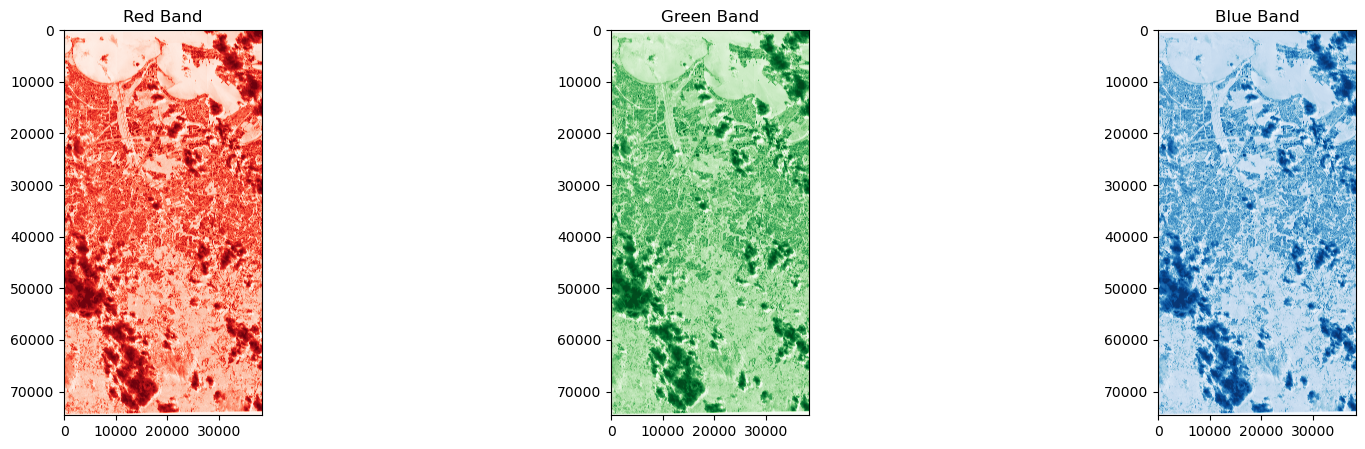

In [12]:
load_and_visualize(pre_event_image)

In [ ]:
# load_and_visualize(post_event_image) # not running it because it takes too much of the cloud memory.

## Data Pre Processing 

### Generating Tiles

<div align="justify"> In this project, we are using only post-event images to create the training dataset. Since there is a vast amount of data, it will lead to heavy work if we mix the pre-event images and post event images. Instead, when labeling, we open the pre-event images and compare them with the corresponding region of the post-event image to identify whether the building is damaged or not (comparison based approach). 

Now, we proceed to create grids for the post-event images, this facilitates the processing of GeoTiFF imagse, and these grids will be saved in a specified directory. We create these grids using a function named <i><b>generate_tiles</b></i>. This function takes a .tiff image and the grid size, then transforms them into grids. In this specific case, we've made grids measuring as suggested by the competition 512x512. </div>

<p><b>Note:</b> This process may take few minutes to generate the grids.</p>

In [ ]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [ ]:
input_file = "./Pre_Event_San_Juan.tif"
output_dir = "./Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir,grid_x,grid_y)

### Creating Geolocation Meta Data

The data labeling which is image annotation in our case, is quite a difficult task as it involves judging the status of a house based on just the 30cm resolution images. 

Therefore, we need as much additional information as possible to accurately identify the building type and the damage status. Getting the geo-coordinates allows us to look for the area on Google maps to identify the rough estimation of the building type based on the map labels.  

*This part of the code used partial AI generate code together with the verification due to the task complicatioin to achieve desired effects.*

In [ ]:
def calculate_tile_coordinates_with_earth_coords(input_file, output_dir, grid_x, grid_y):
    ds = gdal.Open(input_file)
    if ds is None:
        raise FileNotFoundError(f"Could not open input file: {input_file}")

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize

    # Get the CRS of the input image
    input_crs = ds.GetProjection()
    source_spatial_ref = osr.SpatialReference()
    source_spatial_ref.ImportFromWkt(input_crs)

    # Create a spatial reference object for WGS84
    target_spatial_ref = osr.SpatialReference()
    target_spatial_ref.ImportFromEPSG(4326)  # WGS84

    # Coordinate transformation
    coord_transform = osr.CoordinateTransformation(source_spatial_ref, target_spatial_ref)

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x) + (1 if width % grid_x != 0 else 0)
    num_tiles_y = (height // grid_y) + (1 if height % grid_y != 0 else 0)

    tile_coordinates = {} # Dictionary to store tile filenames and their corresponding Earth coordinates

    # Get geotransform of the input file
    geotransform = ds.GetGeoTransform()

    # Iterate over each tile position
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i * grid_x
            y_offset = j * grid_y

            # Calculate the coordinates of the upper left corner of the tile
            upper_left_x = geotransform[0] + x_offset * geotransform[1]
            upper_left_y = geotransform[3] + y_offset * geotransform[5]

            # Transform to WGS84
            upper_left_lon, upper_left_lat, _ = coord_transform.TransformPoint(upper_left_x, upper_left_y)[:3]

            # Calculate the dimensions of the tile, considering edges
            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            # Calculate the coordinates of the lower right corner of the tile
            lower_right_x = upper_left_x + tile_width * geotransform[1]
            lower_right_y = upper_left_y + tile_height * geotransform[5]

            # Transform to WGS84
            lower_right_lon, lower_right_lat, _ = coord_transform.TransformPoint(lower_right_x, lower_right_y)[:3]

            # Create output filename for the tile
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")

            # Update coordinates in the dictionary
            tile_coordinates[output_file] = [(upper_left_lon, upper_left_lat), (lower_right_lon, lower_right_lat)]

    return tile_coordinates


In [ ]:
results = calculate_tile_coordinates_with_earth_coords(input_file, output_dir, grid_x, grid_y)

In [ ]:
# save the geo-coordinate results to a json file.
file_path = "coordinates_file_name_real.json"
with open(file_path, 'w') as json_file:
    json.dump(results, json_file)

### Randomly Pick 150 Images for Data Labeling

As there are 10730 images (tiles), with our limitations to manually label all of the data, we decided to randomize the samples and give each of us (Yutong and Chorobek) 150 images to label.

Despite having access to geo-coordinates with our data, the validation set from the competition and the model itself were not designed to incorporate coordinates, as required by the competition. Therefore, we utilized random sampling of data for labeling, however, since we had a visual access to the validation set, we tried our best to label and select images which were similar to it (validation data).


In [ ]:
directory = './Post_Event_Grids_In_JPEG'
extensions = ['.jpg', '.jpeg', '.png']
all_image_files = [file for file in os.listdir(directory) if os.path.splitext(file)[1].lower() in extensions]
random.shuffle(all_image_files)
selected_files_yutong = all_image_files[:150]
selected_files_chorobek = all_image_files[150:300]
df = pd.DataFrame({'Yutong': selected_files_yutong, 'Chorobek': selected_files_chorobek})
df.to_csv('Week_2_selected_image_files.csv', index=False)

In [ ]:
csv_file_path = 'Week_2_selected_image_files.csv'
df = pd.read_csv(csv_file_path)

filenames = df['Chorobek'].tolist()

output_folder = 'chorobek_files_pre'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

source_folder = './Pre_Event_Grids_In_JPEG'

for filename in filenames:
    if not filename.endswith('.jpg'):
        filename += '.jpg'
    source_file = os.path.join(source_folder, filename)
    destination_file = os.path.join(output_folder, filename)
    if os.path.exists(source_file):
        shutil.copy(source_file, destination_file)
    else:
        print(f"File not found: {source_file}")

print("Files have been copied to the 'chorobek_files_pre' folder.")

### Zipping the images files

Since we are using Jupyter Cloud to compute, uploading a zip folder is the most effective way of doing it.  
*This section used AI generated code to achieve effficiency.*

In [ ]:
import zipfile
from shutil import copy2 

# Simulated function to copy files from a source directory to a target directory
def copy_files(file_paths, directory):
    os.makedirs(directory, exist_ok=True)
    for file_path in file_paths:
        if pd.notna(file_path):  # check if the file path is not NaN
            # Simulate copying the file from the current repo to the target directory
            target_path = os.path.join(directory, os.path.basename(file_path))
            copy2("./Post_Event_Grids_In_JPEG/"+file_path, target_path)  # Simulating file copy

# Function to zip the contents of a directory
def zip_directory(directory, zip_name):
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory):
            for file in files:
                zipf.write(os.path.join(root, file), arcname=os.path.relpath(os.path.join(root, file), os.path.join(directory, '..')))

csv_file_path = './Week_2_selected_image_files.csv'
file_urls_df = pd.read_csv(csv_file_path)

# Directories for each individual
yutong_dir = './yutong_files'
chorobek_dir = './chorobek_files'

# Copy files for Yutong
copy_files(file_urls_df['Yutong'].dropna(), yutong_dir)

# Copy files for chorobek
copy_files(file_urls_df['Chorobek'].dropna(), chorobek_dir)

# Zip the directories
zip_directory(yutong_dir, f'{yutong_dir}.zip')
zip_directory(chorobek_dir, f'{chorobek_dir}.zip')

print(f"Files for Yutong and chorobek have been copied and zipped into '{yutong_dir}.zip' and '{chorobek_dir}.zip', respectively.")


## Annotating the Images

<div align ="justify">Image annotation is the process of labelling images in a given dataset to train machine learning models. When the manual annotation is completed, labelled images are processed by a machine learning or deep learning model to replicate the annotations without human supervision. Image annotation sets the standards, which the model tries to copy, so any error in the labels is replicated too. Therefore, precise image annotation lays the foundation for neural networks to be trained, making annotation one of the most important tasks in computer vision. Inorder to annotate images, we will convert them to .jpg images - EY Challenge</div>

<div align="justify">Each annotation instrument provides a unique image annotation file format. In this project, we will be using <a href = "https://pypi.org/project/labelme/">LabelMe</a> to annotate the images. Since LabelMe does not support .Tiff format we will convert these grids to .jpg/.png format.</div>

### Identifying Damaged and Undamged Infrastructure (EY Challenge)

<div align= "justify">Commercial structures often have larger rooftops and typically have parking areas. In contrast, residential buildings generally have more limited roof space. Buildings deemed as damaged often exhibit roof impairments, while those classified as undamaged have no visible damages. To further grasp the distinctions between damaged and undamaged buildings in both commercial and residential categories, please refer the <a href = "https://challenge.ey.com/api/v1/storage/admin-files/2513955341204317-65bb9169868dc8fadbfc9728-2024%20EY%20Open%20Science%20Data%20Challenge%20Participant%20Guidance.pdf">guidance document</a>. The document is designed to provide a more detailed and comprehensive understanding of these topics.</div>

<div align = "justify">In conclusion, it is safe to assert that the most challenging aspect of the entire model-building task is discerning between residential and commercial structures and the pinpointing of damaged building. </div>

### Converting Images to .png/.jpg images

<div align="justify">Since our annotation tool requires images to be in .jpg/.png format, we proceed to convert the grids from .tiff format to .jpg format, this facilitates the processing of GeoTiFF image, and these grids in .jpg/.png will be saved in a specified directory such as Pre_Event_Grids_In_JPEG. We convert these grids using a function named <i><b>convert_tiff_to_jpeg</b></i>.This function takes the folder with .tiff image as input and the output directory path, where these converted images need to be saved. (Guided by EY Challenge)</div>

In [ ]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [ ]:
# specify directory
input_dir = "./Pre_Event_Grids_In_TIFF"
output_dir = "./Pre_Event_Grids_In_JPEG"
convert_tiff_to_jpeg(input_dir,output_dir)

### Renaming the Files

<div align = "justify">For easier and more efficient data accessibility, it's necessary to rename the files in the directory. We'll use the function <b><i>rename_files</b></i> to accomplish this task of altering the file names in the given path. (Guided by EY Challenge)</div>

In [ ]:
def rename_files(directory_path):
    directory_path = directory_path
    
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    
    # Define a prefix for the new file names 
    # Change the prefix as per requirement
    prefix = "Post_Event_"
    
    # Start the numbering from 1
    number = 0
    
    # Loop through each file in the directory
    for filename in files:
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]
    
            # Create the new file name with leading zeros
            new_filename = f"{prefix}{number:03}{file_extension}"
    
            # Construct the full path to the original and new files
            old_filepath = os.path.join(directory_path, filename)
            new_filepath = os.path.join(directory_path, new_filename)
    
            # Rename the file
            os.rename(old_filepath, new_filepath)
    
            # Increment the number for the next file
            number += 1
    
    print("Files renamed successfully.")

In [ ]:
rename_files(output_dir)

### Introduction to LabelMe - EY Challenge

<div align = "justify">LabelMe is a renowned, open-source, graphical annotation tool perfect for annotating images and videos. The tool is Python-based and integrates Qt for its graphical interface. With its light nature and simple to use interface, LabelMe is a preferred option for an open-source visual annotation tool.</div><br>

<div align="justify">LabelMe provides functionalities to facilitate annotations for object identification, semantic segmentation, and panoptic segmentation for both image and video data. Additionally, it also aids in addressing various computer vision issues like classification and segmentation. With LabelMe, users can create annotations using circles, rectangles (bounding boxes), lines, and polygons.</div><br>

<div align="justify">Annotations are integral to the success of object recognition tasks. By labeling or annotating objects in a given set of images, we pinpoint to the model what to look for. Therefore, it is not only advisable but highly beneficial to annotate as many objects as possible.</div>

#### Naming convention of class label

<table>
  <tr>
    <th>Object</th>
    <th>Naming Convention</th>
  </tr>
  <tr>
    <td>Undamaged Residential Building</td>
    <td>undamagedresidentialbuilding</td>
  </tr>
  <tr>
    <td>Damaged Residential Building</td>
    <td>damagedresidentialbuilding</td>
  </tr>
   <tr>
    <td>Undamaged Commercial Building</td>
    <td>undamagedcommercialbuilding</td>
  </tr>
     <tr>
    <td>Damaged Commercial Building</td>
    <td>damagedcommercialbuilding</td>
  </tr>
</table>


Here we have annotated around 150 images of which 80% images will be used for training and the rest 20% as test set.

### YOLO Annotations Format and Train Test Split

<div align="justify">Since, YOLO algorithms requires the annotations to be in a specific format labels generated using LabelMe annotation tool should be exported to YOLO format with one *.txt file per image. If there are no objects in an image, no *.txt file is required. In case of bounding box annotations the *.txt file should be formatted with one row per object in class x_center y_center width height format. Box coordinates must be in normalized xywh format (from 0 to 1). If the boxes are in pixels, one should divide x_center and width by image width, and y_center and height by image height. Class numbers should be zero-indexed (start with 0).</div>

<div align = "justify"> By default, labelme2yolo package converts LabelMe annotations to <a href ="https://docs.ultralytics.com/datasets/obb/#yolo-obb-format"> YOLO OBB </a> format which has been used to build this model. The YOLO OBB format designates bounding boxes by their four corner points with coordinates normalized between 0 and 1. It follows this format: class_index, x1, y1, x2, y2, x3, y3, x4, y4. Internally, YOLO processes losses and outputs in the xywhr format, which represents the bounding box's center point (xy), width, height, and rotation. In order to get annotations in bounding box format  (x,y,w,h) we need to pass the parameter <i>--output_format bbox</i>. </div>

<div align = "justify">As for config the train and test validation split, by default, 80% of the data is considered for Training Data and the rest of the 20% for the test data. </div> 

#### Generating Train and Test Data along with Configuration File

In [ ]:
# !labelme2yolo --json_dir /path/to/labelme_json_dir/
!labelme2yolo --json_dir ./delte/

## Preparing the File Structure as required by YOLO 
<div align ="justify">The file need to be structured as indicated below and adjust the dataset.yaml settings according to the file path provided.</div>

### File Structure
<div align="justify">YOLOv8, being a Deep Learning model for object detection, necessitates a specific directory framework for running effectively. The fundamental structure has a parent folder titled 'datasets', which further contains two subfolders: 'train', and 'val'.</div><br>

<div align="justify">The 'datasets' folder: As the name indicates, this folder houses the complete data that YOLOv8 will be working on. It is pivotal as the model gains insight, verifies accuracy, and enhances its effectiveness using the data stored here.</div><br>

<div align="justify">The 'train' subfolder: This is a subset of the datasets folder and houses a collection of both image files (.jpg format) and their corresponding annotation files (.txt format). The training data is used by the model to learn and create a mathematical function that can predict the output.</div><br>

<div align="justify">The 'val' subfolder: Similarly, this contains the test images and their corresponding annotations. The test data is not learned by the model. Instead, it's used to evaluate the performance of the model's learning.</div><br>

<div align="justify">The 'dataset.yaml' file: This is a vital document that encompasses critical details concerning the dataset and the manners of their use. It contains paths for training, testing, and their respective numbers of images, the total count of classes, and class labels. This is generated in the previous section - <b>YOLO Annotations Format and Train Test Split</b></div><br>

The files need to be organised in the following manner:
<ul>
    <li> dataset.yaml </li>
    <li>datasets</li>
<ul>
    <li> train </li>
    <ul>
        <li>image1.jpg</li>
        <li>image1.txt</li>
        <li>image2.jpg</li>
        <li>image2.txt</li>
        <li>image3.jpg</li>
        <li>image3.txt</li>
    </ul>
    <li> val</li>
    <ul>
        <li>image4.jpg</li>
        <li>image4.txt</li>
        <li>image5.jpg</li>
        <li>image5.txt</li>
        <li>image6.jpg</li>
        <li>image6.txt</li>
    </ul>
 
</ul>
    

   

## Model Building
<div align="justify">

Once the file structure is set up, we can proceed to the exercise of building the model. Throughout this point, we continually assess the performance of our model using metric like mean average precission (mAP).</div>

<div align="justify">Post-training, the model needs to be validated using a different dataset to further confirm that it works accurately when exposed to unseen data. Lastly, it is our goal to ensure model does not overfit or underfit. An overfit model implies it is too complex and may not work well with new data, while an underfit model implies the model misses the relevant relations between features and target outputs.</div><br>

### Model Training

<div align ="justify">Now that we have the data in a format appropriate for developing the model, we can begin training a model. In this demonstration notebook, we have used pre-trained object detection model from YOLOv8 (yolov8n.pt) developed by Ultralytics. </div>

In [7]:
model = YOLO('yolov8n.pt')
model.info()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [8]:
print(os.getcwd())
os.chdir('/home/jovyan/PlanetaryComputerExamples/EY2024')

/home/jovyan/PlanetaryComputerExamples/EY2024


In [10]:
results = model.train(data='./dataset.yaml', epochs=50, imgsz=512)

Ultralytics YOLOv8.1.47 🚀 Python-3.11.8 torch-2.2.2+cu121 CPU (Intel Xeon Platinum 8272CL 2.60GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

train: Scanning /home/jovyan/PlanetaryComputerExamples/EY2024/datasets/annotations_choro/YOLODataset/labels/train.cache... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<?, ?it/s]
val: Scanning /home/jovyan/PlanetaryComputerExamples/EY2024/datasets/annotations_choro/YOLODataset/labels/val.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]

Plotting labels to runs/detect/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.928      4.201      1.694        324        512: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         12        199    0.00312      0.106    0.00394    0.00234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50         0G      1.855      4.195      1.567        300        512: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         12        199    0.00365      0.129    0.00617    0.00302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.616      4.047      1.437        372        512: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         12        199    0.00367      0.144     0.0135     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.519       3.84      1.265        380        512: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         12        199    0.00399      0.133     0.0192     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.462      3.501      1.284        256        512: 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         12        199    0.00532      0.132     0.0185     0.0132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.479      3.324      1.175        407        512: 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         12        199    0.00566      0.137      0.012     0.0087

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/50         0G      1.438      3.177      1.166        525        512: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         12        199    0.00695      0.176     0.0208      0.014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.446      2.863      1.175        311        512: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         12        199     0.0141      0.255       0.06     0.0328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/50         0G      1.445      2.634      1.186        236        512: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         12        199     0.0178      0.314     0.0958     0.0552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.415      2.487      1.138        337        512: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         12        199     0.0197      0.361      0.112     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.424      2.454      1.191        389        512: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         12        199     0.0218      0.419      0.136     0.0798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.447      2.285      1.168        313        512: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         12        199     0.0253      0.489      0.171      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.484      2.188      1.184        374        512: 100%|██████████| 3/3 [00:07<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         12        199       0.33      0.209      0.227      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.439      2.152       1.17        372        512: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         12        199      0.404      0.132      0.228      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.467      2.093      1.179        411        512: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         12        199       0.42      0.163      0.218      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/50         0G      1.401       2.14      1.135        261        512: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         12        199      0.303      0.204        0.2      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/50         0G      1.363      1.878      1.119        478        512: 100%|██████████| 3/3 [00:08<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         12        199      0.345      0.312      0.249      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.403      1.872      1.124        491        512: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         12        199      0.266      0.298      0.257      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.377      1.786      1.136        373        512: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         12        199      0.316      0.356      0.267      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.339      1.776      1.127        306        512: 100%|██████████| 3/3 [00:07<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         12        199      0.296        0.4       0.27      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.337      1.726      1.144        258        512: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         12        199      0.304      0.438      0.276      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.368      1.752      1.158        402        512: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         12        199      0.305      0.436      0.321      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.393      1.688      1.169        364        512: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         12        199      0.335      0.447       0.33      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.332      1.653      1.129        262        512: 100%|██████████| 3/3 [00:07<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         12        199      0.303      0.461      0.316       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/50         0G       1.34      1.726      1.127        371        512: 100%|██████████| 3/3 [00:07<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         12        199      0.286      0.392       0.32      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/50         0G      1.294      1.655      1.116        341        512: 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         12        199      0.348      0.404      0.353      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.369      1.792       1.13        405        512: 100%|██████████| 3/3 [00:07<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         12        199      0.383      0.395      0.364      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.364      1.634      1.125        316        512: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         12        199      0.395      0.428      0.351      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/50         0G      1.274      1.449      1.111        288        512: 100%|██████████| 3/3 [00:07<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         12        199      0.395      0.428      0.351      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/50         0G      1.288      1.478      1.108        331        512: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         12        199      0.386        0.4      0.322      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/50         0G      1.311      1.643      1.083        403        512: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         12        199       0.39       0.41      0.316      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/50         0G      1.282      1.499      1.108        405        512: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         12        199      0.407      0.407      0.329      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/50         0G      1.296      1.499      1.097        409        512: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         12        199      0.407      0.407      0.329      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/50         0G      1.273       1.36      1.112        265        512: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         12        199      0.429      0.442      0.327      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/50         0G      1.296      1.395       1.09        379        512: 100%|██████████| 3/3 [00:08<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         12        199      0.356      0.414      0.334      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      36/50         0G      1.273      1.489      1.077        323        512: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         12        199      0.442       0.44      0.343      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      37/50         0G      1.255      1.431      1.098        331        512: 100%|██████████| 3/3 [00:08<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         12        199      0.442       0.44      0.343      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      38/50         0G      1.279      1.545      1.081        469        512: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         12        199      0.475      0.454      0.343      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      39/50         0G      1.277      1.515      1.098        335        512: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         12        199      0.407      0.441      0.351      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      40/50         0G      1.228      1.359      1.098        404        512: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         12        199      0.427      0.474      0.361      0.203


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.275       1.62      1.152        222        512: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         12        199      0.427      0.474      0.361      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.258      1.512      1.155        188        512: 100%|██████████| 3/3 [00:06<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         12        199      0.456      0.471      0.379      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.258      1.506      1.132        308        512: 100%|██████████| 3/3 [00:06<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         12        199       0.44      0.489      0.391      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.276      1.531      1.131        155        512: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         12        199      0.458      0.469      0.395      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.252      1.454      1.089        161        512: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         12        199      0.458      0.469      0.395      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.254      1.372      1.093        199        512: 100%|██████████| 3/3 [00:06<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         12        199       0.48      0.471      0.398      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.223      1.468      1.103        196        512: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         12        199      0.485      0.481      0.404       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G       1.22      1.427      1.111        280        512: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         12        199      0.479      0.488      0.408      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      49/50         0G      1.222      1.386      1.096        229        512: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         12        199      0.479      0.488      0.408      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.261      1.545      1.099        117        512: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         12        199      0.471      0.495       0.41       0.24



50 epochs completed in 0.122 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.11.8 torch-2.2.2+cu121 CPU (Intel Xeon Platinum 8272CL 2.60GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


                   all         12        199       0.47      0.495       0.41      0.241
undamagedresidentialbuilding         12         44      0.387      0.477      0.369      0.215
damagedresidentialbuilding         12         81      0.278       0.84       0.43      0.248
undamagedcommercialbuilding         12         13      0.818      0.385      0.498      0.332
damagedcommercialbuilding         12         61      0.398      0.279       0.34      0.168
Speed: 0.8ms preprocess, 34.1ms inference, 0.0ms loss, 18.3ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# results_tune = model.tune(data='./dataset.yaml', epochs=50, 
#            iterations=5, optimizer='AdamW', 
#            plots=True, save=False, val=False)

## Model Evaluation

<div align ="justify">Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the mean average precission report. </div>

<div align ="justify">From the above results (train14) above we can see that we achieved an overall MAP-50 of 0.41 based on cross validation test.
<ul>
    <li>Undamaged Commercial Building -0.498</li>
    <li>Undamaged Residential Building -0.369</li>
    <li>Damaged Residential Building - 0.43</li>
    <li>Damaged Commercial Building 0.34</li>

<div align ="justify"> With an mAP score of 0.34 and 0.369, the model struggles when it comes to detecting damaged commercial buildings and undamaged residential buildings.</div>

## Submission - Guided by EY Challange

### Download submission images from platform

In [ ]:
def unzip_folder(zip_filepath, dest_dir):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    print(f'The zip file {zip_filepath} has been extracted to the directory {dest_dir}')

submission_zip = './annotations_choro.zip'
submission_directory = './sieben_annotations_choro'
unzip_folder(submission_zip,submission_directory)

### Making Predictions on the Submission Data

In [ ]:
# Load the Model
model = YOLO('./runs/detect/train/weights/best.pt')

In [ ]:
# Decoding according to the .yaml file class names order
decoding_of_predictions ={0: 'undamagedcommercialbuilding', 1: 'undamagedresidentialbuilding', 2: 'damagedresidentialbuilding', 3: 'damagedcommercialbuilding'}

directory = 'challenge_1_submission_images'
# Directory to store outputs
results_directory = 'Validation_Data_Results'

# Create submission directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the current object is a file and ends with .jpeg
    if os.path.isfile(os.path.join(directory, filename)) and filename.lower().endswith('.jpg'):
        # Perform operations on the file
        file_path = os.path.join(directory, filename)
        print(file_path)
        print("Making a prediction on ", filename)
        results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)
        
        for r in results:
            conf_list = r.boxes.conf.numpy().tolist()
            clss_list = r.boxes.cls.numpy().tolist()
            original_list = clss_list
            updated_list = []
            for element in original_list:
                 updated_list.append(decoding_of_predictions[int(element)])

        bounding_boxes = r.boxes.xyxy.numpy()
        confidences = conf_list
        class_names = updated_list

        # Check if bounding boxes, confidences and class names match
        if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
            print("Error: Number of bounding boxes, confidences, and class names should be the same.")
            continue
        text_file_name = os.path.splitext(filename)[0]
        # Creating a new .txt file for each image in the submission_directory
        with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
            for i in range(len(bounding_boxes)):
                # Get coordinates of each bounding box
                left, top, right, bottom = bounding_boxes[i]
                # Write content to file in desired format
                file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
        print("Output files generated successfully.")


<b>Note: The submission file should contain only the .txt files and not the images.</b> 

In [ ]:
source_dir = results_directory
destination_zip = 'submission'

# Create a zip file from the directory
shutil.make_archive(destination_zip, 'zip', source_dir)

print(f"Directory {source_dir} has been successfully zipped into {destination_zip}.")

### Upload submission file on platform.